In [1]:
import drawsvg as dw
from os import listdir
dir = '/home/jh/src/svg/lib'
files = listdir(dir)
for file in files:
    if file[-3:] == '.py':
        f = '%s/%s' % (dir,file)
        exec(open(f).read())

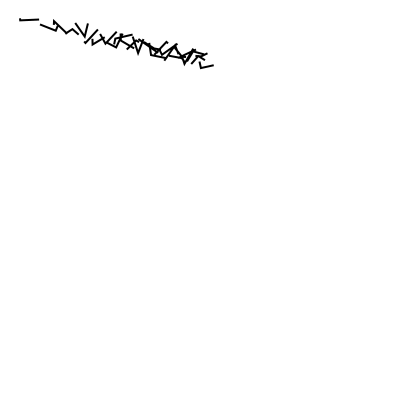

In [14]:
d = dw.Drawing(200,200)

def krachen(xstart=10,ystart=10,xend=100,yend=30,yrange=10,sw=1,c='black',
            lenminmax=(5,10),densminmax=(1,5),**args):
    """kleine krackel für elektronik 120 in bizarre plätze
    schneidet hinten nicht ab, sondern lässt die kleinen krackel auslaufen"""
    from random import uniform
    # länge der einzelnen elemente
    lmin,lmax = lenminmax
    # element pro 10 pixel am anfang und am ende
    densmin,densmax = densminmax
    x = xstart
    p = dw.Path(fill='none',stroke=c,stroke_width=sw,**args)
    while x < xend:
        # wo ist der y mittelpunkt
        y = ystart + (x-xstart) * ((yend-ystart)/(xend-xstart))
        # endpunkt dieses krackels
        xmax = x + uniform(lmin,lmax)
        # welche density hier
        dens = densmin + (x-xstart) * ((densmax-densmin)/(xend-xstart))
        p1 = x,y+uniform(-yrange/2,yrange/2)
        p2 = uniform(x,xmax),y+uniform(-yrange/2,yrange/2)
        p3 = xmax,y+uniform(-yrange/2,yrange/2)
        p.M(*p1)
        p.L(*p2)
        p.L(*p3)
        x += 10 / dens
    d.append(p)
    
krachen()

    
d.set_pixel_scale(2)
#d.save_png('varVib.png')
#d.save_svg('varVib.svg')
d

In [39]:
help(type)

Help on class type in module builtins:

class type(object)
 |  type(object_or_name, bases, dict)
 |  type(object) -> the object's type
 |  type(name, bases, dict) -> a new type
 |  
 |  Methods defined here:
 |  
 |  __call__(self, /, *args, **kwargs)
 |      Call self as a function.
 |  
 |  __delattr__(self, name, /)
 |      Implement delattr(self, name).
 |  
 |  __dir__(self, /)
 |      Specialized __dir__ implementation for types.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __instancecheck__(self, instance, /)
 |      Check if an object is an instance.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __setattr__(self, name, value, /)
 |      Implement setattr(self, name, value).
 |  
 |  __sizeof__(self, /)
 |      Return memory consumption of the type object.
 |  
 |  __subclasscheck__(self, subclass, /)
 |     